# 04 - Applied ML

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
import seaborn as sns
%matplotlib inline

In [20]:
data = pd.read_csv('lalonde.csv')
data.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.301303,27.363192,10.268730,0.395765,0.117264,0.415309,0.630293,4557.546569,2184.938207,6792.834483
std,0.459198,9.881187,2.628325,0.489413,0.321997,0.493177,0.483119,6477.964479,3295.679043,7470.730792
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,238.283425
50%,0.000000,25.000000,11.000000,0.000000,0.000000,0.000000,1.000000,1042.330000,601.548400,4759.018500
75%,1.000000,32.000000,12.000000,1.000000,0.000000,1.000000,1.000000,7888.498250,3248.987500,10893.592500
max,1.000000,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


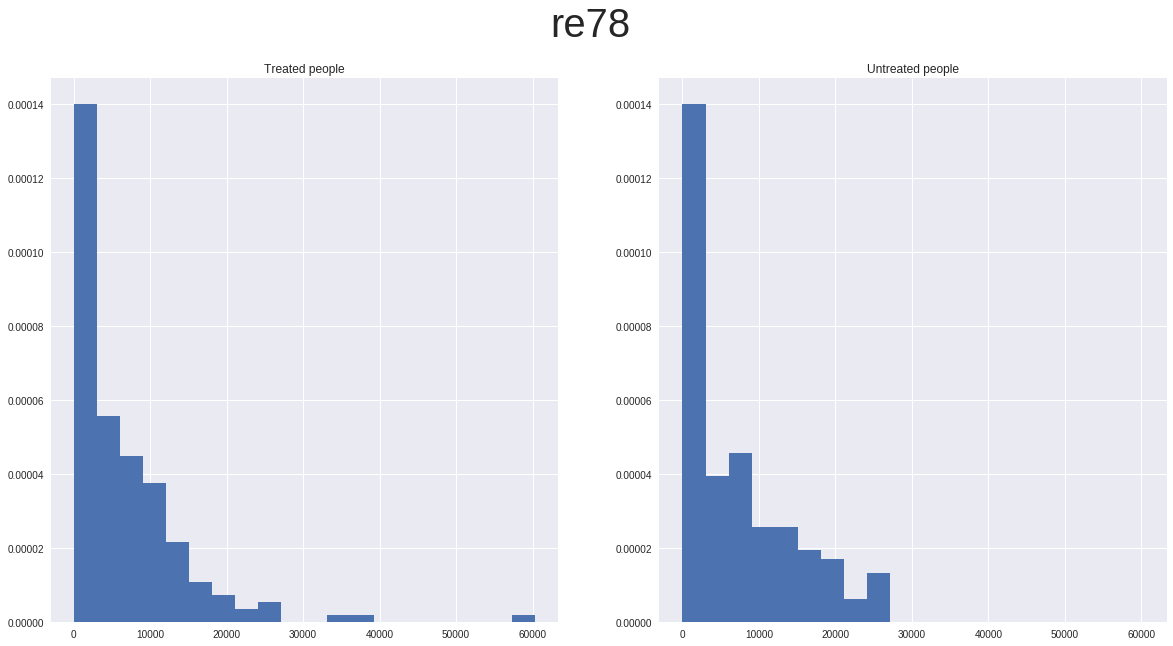

In [77]:
data_treated = data[data["treat"] == 1]
data_untreated = data[data["treat"] == 0]

def plot_feature(feature_name):
    r_min = data[feature_name].min()
    r_max = data[feature_name].max()
        
    plt.figure(figsize=(20,10))
    plt.suptitle(feature_name, fontsize=40)
    ax = plt.subplot(1,2,1)
    plt.hist(data_treated[feature_name], normed=True, bins=20, range=(r_min, r_max))
    plt.title("Treated people")
    plt.subplot(1,2,2, sharey=ax)
    plt.title("Untreated people")
    plt.hist(data_untreated[feature_name], normed=True, bins=20, range=(r_min, r_max))
    plt.show()


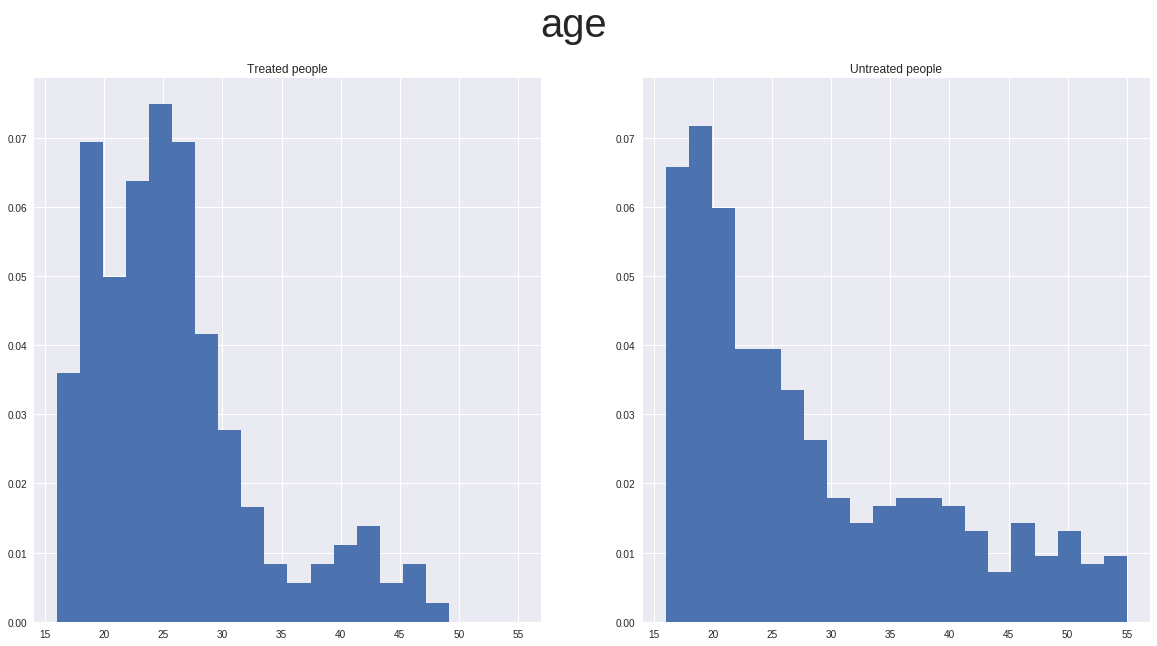

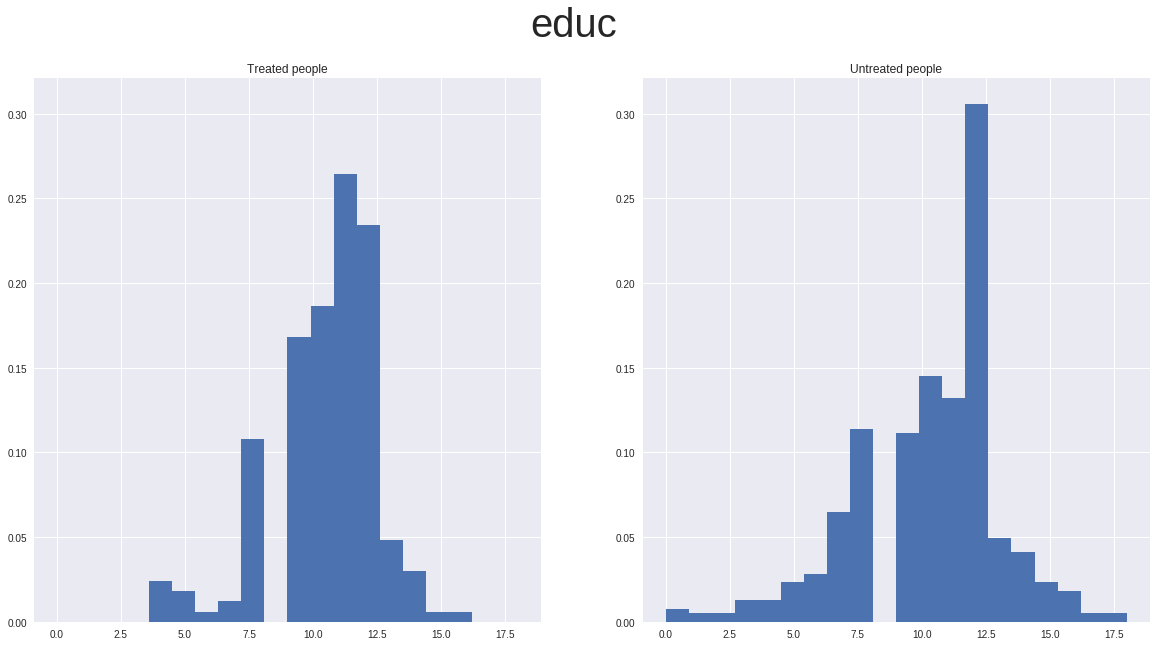

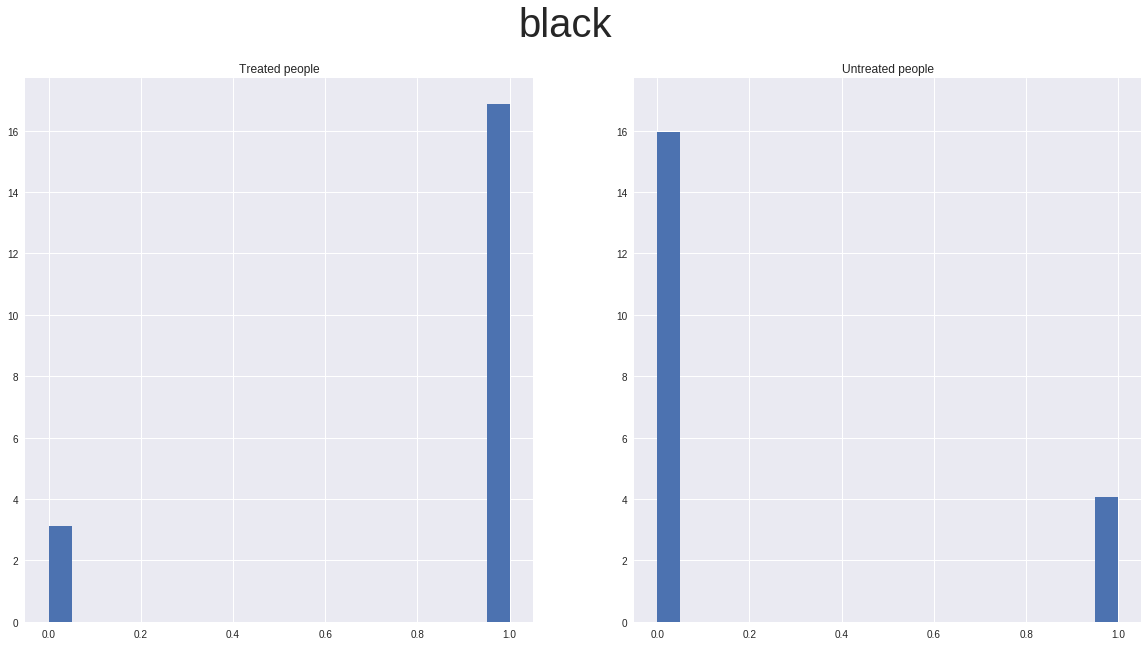

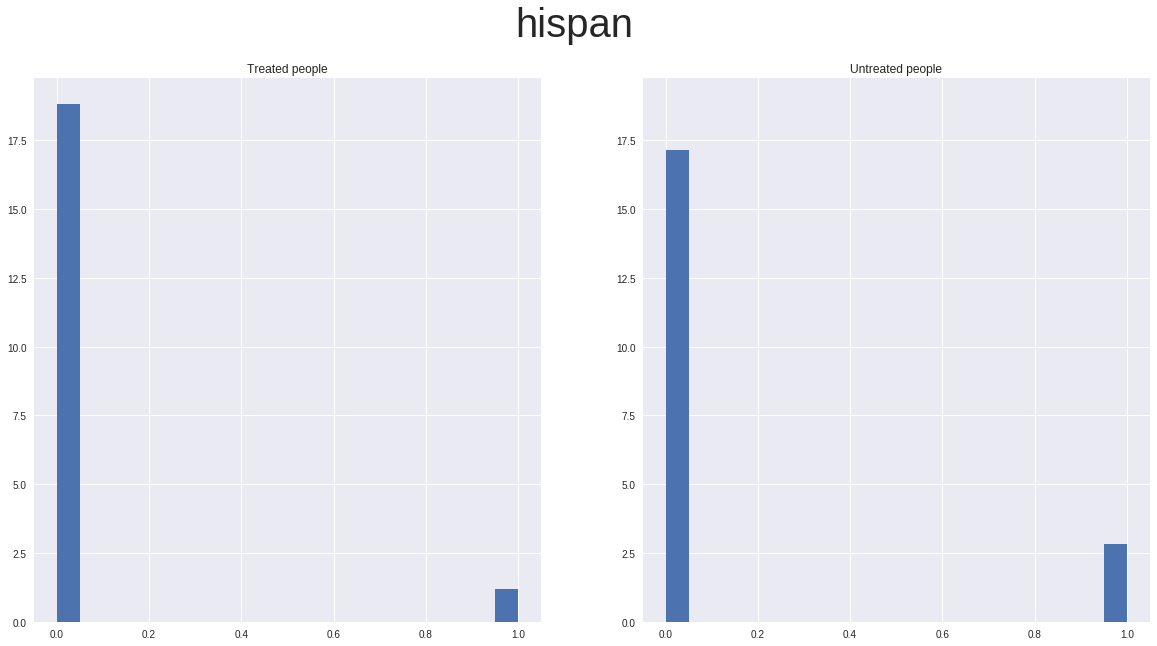

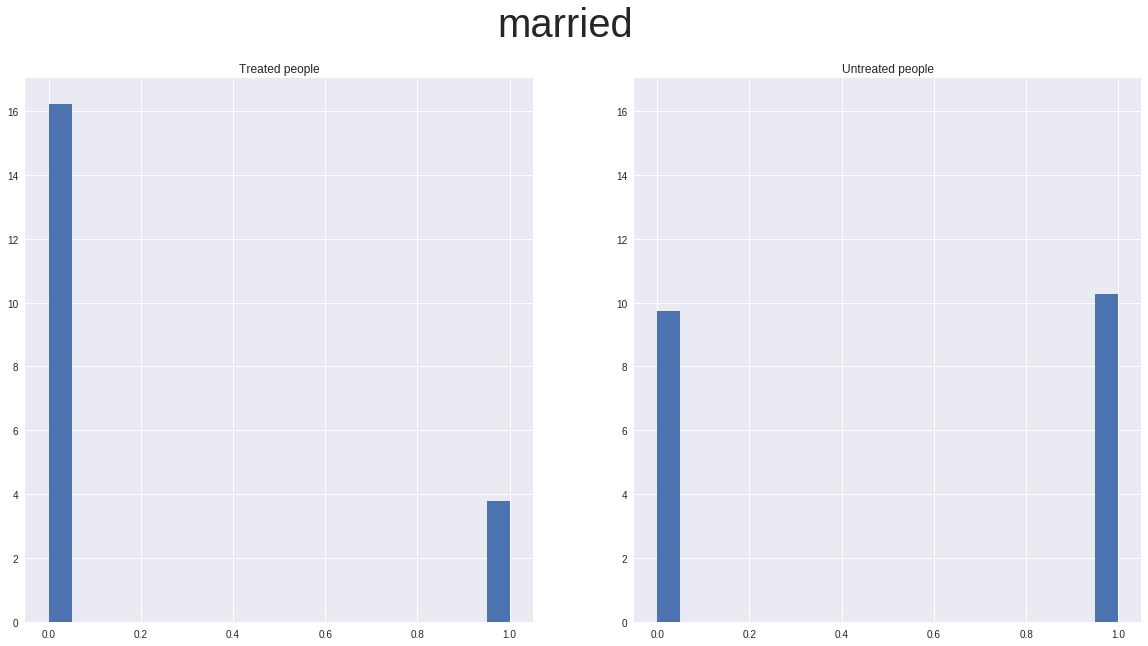

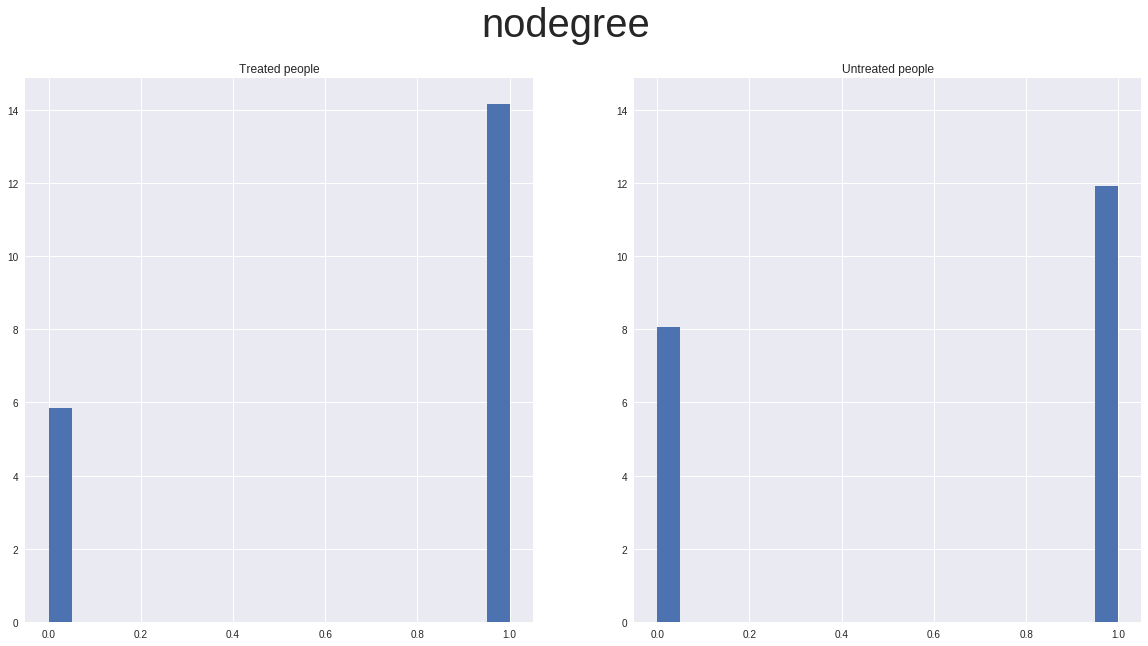

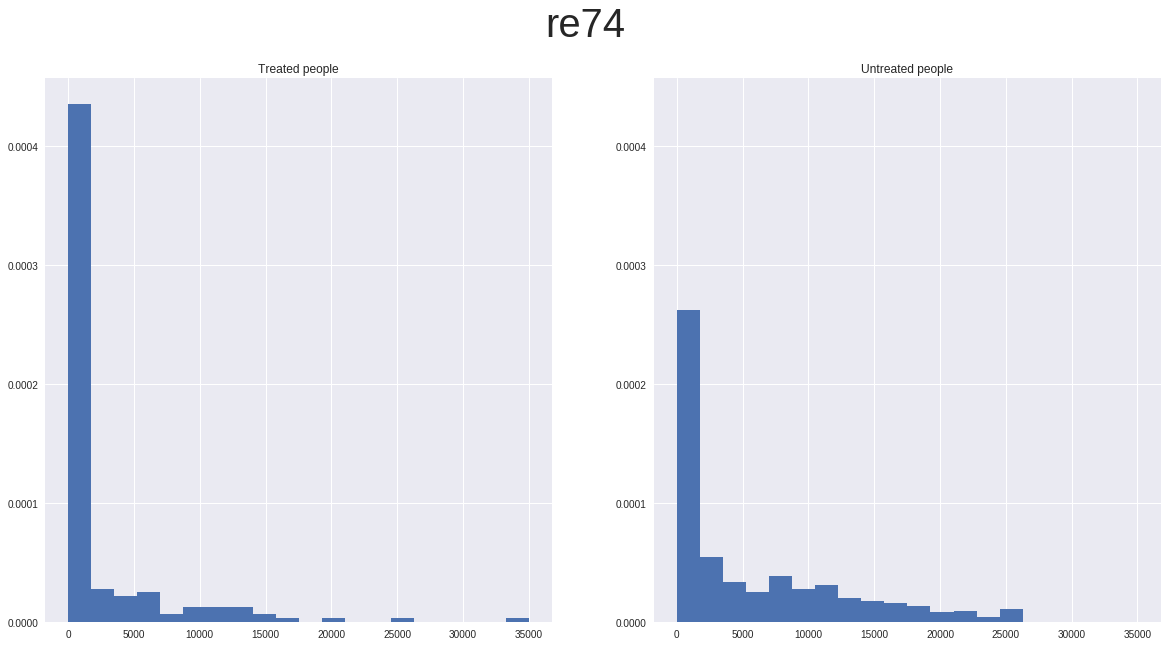

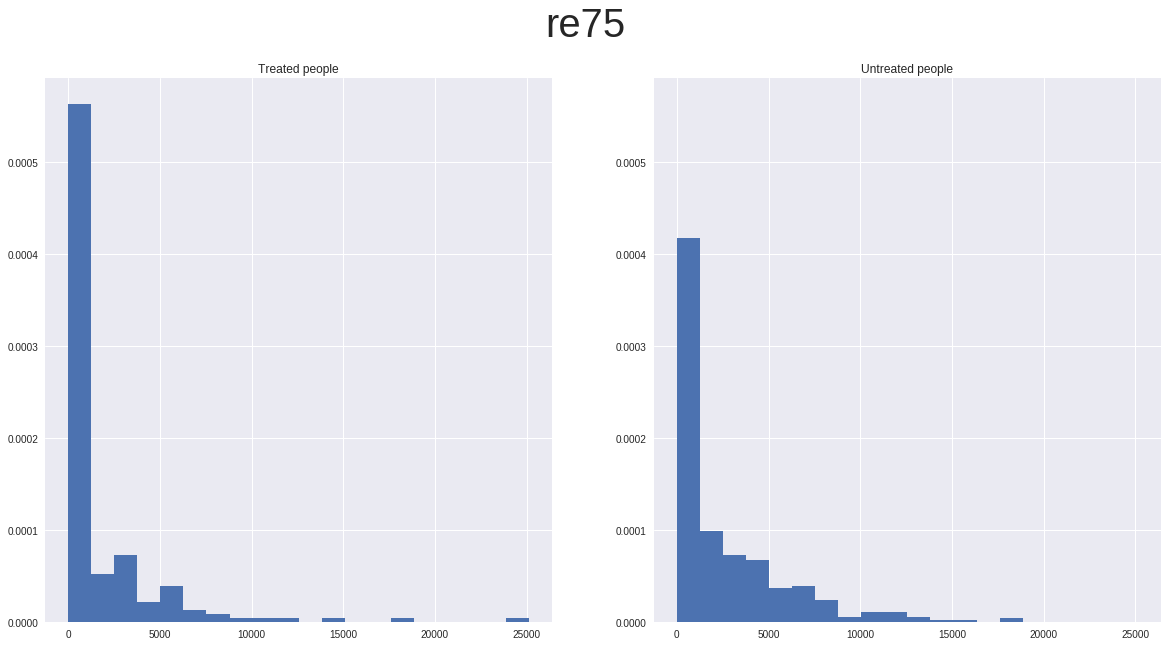

In [78]:
for col in ["age", "educ", "black", "hispan", "married", "nodegree", "re74", "re75"]:
    plot_feature(col)